# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few
days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an
actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain
weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to
which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only
has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days.
You'll see in the data set that informational offers have a validity period even though these ads are merely providing
information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer
is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the
amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as
well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer
or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10
days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer
completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they
receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For
example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during
the 10-day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion
record in the data set; however, the customer was not influenced by the offer because the customer never viewed the
offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an
offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you
wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic
group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a
machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could
build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine
learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer
(i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic
to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and metadata about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# 1. Fetching data and importing libraries

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, plot_roc_curve, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 2. Data Preprocessing and Feature Engineering

In [3]:
def information(df: pd.DataFrame) -> None:
    """
    A helper function that we will use in order to present the basic information of our datasets.
    It's useful in order not to repeat the same lines of code and just keep them all together for functionality.

    Parameters
    ----------
    df:
        pd.DataFrame - the input data that we will be printing its information

    Returns
    -------
    None
    """
    # some basic descriptive statistics
    print('DataFrame description:')
    print(df.describe())

    # here we are going to showcase the number of columns, data points and memory usage
    print('\nColumn and data points information')
    print(df.info())

    # since we have found some missing values we are going to need to show in what attributes they are missing
    print('\nMissing values:')
    print(df.isna().sum())

    # a simple print of the head of the DataFrame
    print('\nHead data representation:')
    print(df.head())


## 2.1 Portfolio information

In [4]:
information(portfolio)

DataFrame description:
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

Column and data points information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None

Missing values:
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id 

From the information provided we can understand that there are 10 types of offers that are recommended to the user, and
they are sent based on the `channels` column, which are either from promotional emails, notifications through their
mobile app, social media promo and through the website.

Visualizing `offer_type` how much these types of offers are promoted by the company.

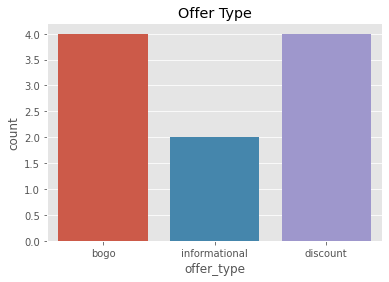

In [5]:
sns.countplot(portfolio['offer_type'])
plt.title('Offer Type')
plt.show()

As it can be seen above we have 4 discount offers, 4 buy one get one and 2 informational offers.

The `id` column is a unique key for the specified offer, but because we also have `id` in the `profile` DataFrame, so we
are going to rename it to `offer_id` in order to avoid confusion. In addition to that we are going to apply one hot
encoding for the `channels` column.

In [6]:
# apply one hot encoding to channels and offer_type columns
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio.drop(['channels'], axis=1, inplace=True)

In [7]:
dummies = pd.get_dummies(portfolio['offer_type'])
new_portfolio = pd.concat([portfolio, dummies], axis=1, sort=False)
new_portfolio.drop(['offer_type'], axis=1, inplace=True)

In [8]:
new_portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [9]:
new_portfolio

,reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


## 2.2 Profile information

In [10]:
orig_profile = profile.copy()
information(profile)

DataFrame description:
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

Column and data points information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2

As we can see there are 2175 missing values on `gender` and `income`.

Also, based on the `head()` print we can see that besides the `None` in `gender` and `NaN` in `income` if we count and
print where `age = 118` we will find that they are the same data points.

In [11]:
print(profile[profile['age'] == 118].head(10))

   gender  age                                id  became_member_on  income
0    None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2    None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4    None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6    None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7    None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN
9    None  118  8974fc5686fe429db53ddde067b88302          20161122     NaN
10   None  118  c4863c7985cf408faee930f111475da3          20170824     NaN
11   None  118  148adfcaa27d485b82f323aaaad036bd          20150919     NaN
17   None  118  744d603ef08c4f33af5a61c8c7628d1c          20170801     NaN
23   None  118  2b826eba31074a059d63b0ae8f50b7d5          20170907     NaN


And it can be confirmed that `age=118` reffers to missed values, so our next step will be to drop these columns in order
not to interfere later on with the training process.

In [12]:
profile.replace(118, np.nan , inplace=True)
profile.replace('None', np.nan , inplace=True)
profile.dropna(inplace=True)
profile.head()

,gender,age,id,became_member_on,income
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


Display the distribution of genders in our customers' profile.

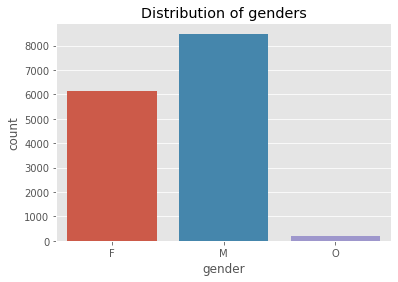

In [13]:
sns.countplot(profile['gender'])
plt.title('Distribution of genders')
plt.show()

And apply one hot encoding to `gender`

In [14]:
dummies = pd.get_dummies(profile['gender'])
new_profile = pd.concat([profile, dummies], axis=1, sort=False)
profile.drop(['gender'], axis=1, inplace=True)

We are going to transform the `became_member_on` in a `datetime` format that will be a lot easier to read and deal with.

In [15]:
new_profile['became_member_on'] = pd.to_datetime(new_profile['became_member_on'], format='%Y%m%d')
new_profile.head()

,gender,age,id,became_member_on,income,F,M,O
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0


As we mentioned above, we are going also to rename `id` to `customer_id` for ease of use.

In [16]:
new_profile.rename(columns={'id':'customer_id'}, inplace=True)

No. of unique users

In [17]:
new_profile['customer_id'].nunique()

14825

In [18]:
def boxplot(df, attribute):
    values = df[attribute]
    mean = np.array(values).mean()
    median = np.median(values)

    f, (ax_box, ax_hist) = plt.subplots(2, sharex='col', gridspec_kw={'height_ratios': (0.5, 2)})

    sns.boxplot(values, ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.set(xlabel='')
    ax_box.set_title('Distribution of {}'.format(attribute), fontsize=17)

    sns.distplot(values, ax=ax_hist)
    ax_hist.axvline(mean, color='r', linestyle='--')
    ax_hist.axvline(median, color='g', linestyle='-')
    plt.legend({'Mean':mean,'Median':median})
    plt.show()

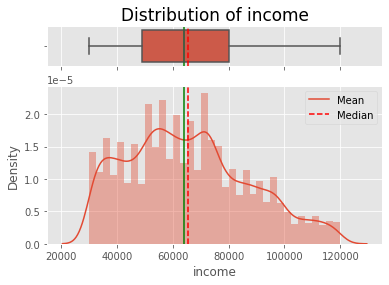

In [19]:
# distribution of income
boxplot(new_profile, 'income')

We are going to create income groups that will have the benefit of categorizing our customer from their income range and
apply one hot encoding.

In [20]:
range_income = pd.cut(x=new_profile['income'], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,
                                                     120000])
income_dummies = pd.get_dummies(range_income)
new_profile = pd.concat([new_profile, income_dummies], axis=1, sort=False)
new_profile.drop(['income'], axis=1, inplace=True)
new_profile.head()

,gender,age,customer_id,became_member_on,F,M,O,"(30000, 40000]","(40000, 50000]","(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]"
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,1,0,0,0,0,0,0,0,0,0,0,1
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1,0,0,0,0,0,0,0,0,1,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,0,1,0,0,0,0,1,0,0,0,0,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,0,1,0,0,0,1,0,0,0,0,0,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,0,1,0,0,0,1,0,0,0,0,0,0


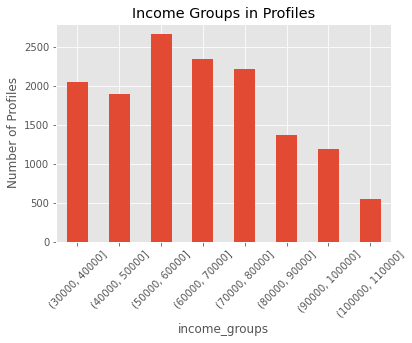

In [21]:
# income groups distribution
new_profile[new_profile.columns[7:15]].sum().plot.bar()
plt.title('Income Groups in Profiles')
plt.ylabel('Number of Profiles')
plt.xlabel('income_groups')
plt.xticks(rotation=45)
plt.show()

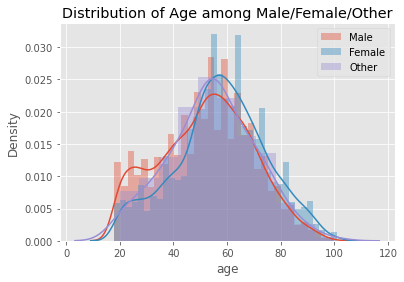

In [22]:
# gender-wise age distribution
sns.distplot(new_profile[new_profile['M']==1]['age'], label='Male')
sns.distplot(new_profile[new_profile['F']==1]['age'], label='Female')
sns.distplot(new_profile[new_profile['O']==1]['age'], label='Other')
plt.title('Distribution of Age among Male/Female/Other')
plt.legend()
plt.show()

In [23]:
# bins=[0, 15, 30, 45, 60, 101], labels=['children', 'young_adults', 'adults', 'middle_age', 'elderly']
# bins=[0, 18, 30, 60, 101], labels=['children', 'young_adults', 'middle_age', 'elderly'])
new_profile['age_groups'] = pd.cut(new_profile.age, bins=[0, 18, 30, 50, 70, 110], labels=['child', 'teen', 'young_adults', 'middle_age_adults', 'elderly'])
new_profile['age_groups'].value_counts()

middle_age_adults    6500
young_adults         3988
elderly              2632
teen                 1635
child                  70
Name: age_groups, dtype: int64

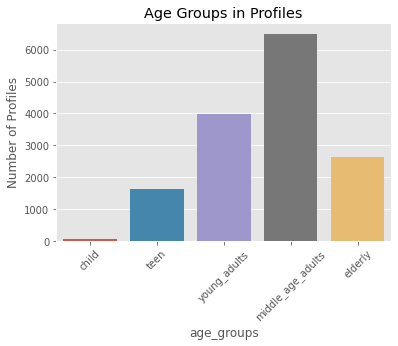

In [24]:
sns.countplot(new_profile['age_groups'])
plt.title('Age Groups in Profiles')
plt.xticks(rotation=45)
plt.ylabel('Number of Profiles')
plt.xlabel('age_groups')
plt.show()

We are also going to apply one hot encoding for the `age_groups` column

In [25]:
dummies = pd.get_dummies(new_profile['age_groups'])
new_profile = pd.concat([new_profile, dummies], axis=1, sort=False)
new_profile.drop(['age_groups'], axis=1, inplace=True)
new_profile.head()

,gender,age,customer_id,became_member_on,F,M,O,"(30000, 40000]","(40000, 50000]","(50000, 60000]",...,"(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",child,teen,young_adults,middle_age_adults,elderly
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 2.3 Transcript information

In [26]:
information(transcript)

DataFrame description:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000

Column and data points information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None

Missing values:
person    0
event     0
value     0
time      0
dtype: int64

Head data representation:
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  off

Here the `person` column refers to the customer, so we are going to rename it to `customer_id` as we have done in the
above cases for ease of use.

In [27]:
transcript.rename(columns={'person':'customer_id'}, inplace=True)
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [28]:
transcript.groupby('event').customer_id.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: customer_id, dtype: int64

We are going to create the "dummy" columns from `value` attribute in order for our models to be able to take them into
consideration.

After that we are going to concat it with the rest of the transcript DataFrame. The transcript table consists of value
columns which contains dictionary values in which the keys are offer id and amount. We need to first extract these keys
before we move on to one hot encoding them.

In [30]:
# functions to create offer_id and amount columns from the transcript table
def create_offer_id_column(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]

def create_amount_column(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]

In [31]:
transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
transcript['amount'] = transcript.value.apply(create_amount_column)

dummies = pd.get_dummies(transcript['event'])
temp_transcript = pd.concat([transcript, dummies], axis=1, sort=False)

transaction = temp_transcript[temp_transcript['transaction']==1]

temp_transcript = temp_transcript.drop(transaction.index)

new_transcript = temp_transcript.drop(columns=['event', 'value', 'amount', 'transaction'])

new_transcript.rename(columns={'person':'customer_id'}, inplace=True)
new_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   customer_id      167581 non-null  object
 1   time             167581 non-null  int64 
 2   offer_id         167581 non-null  object
 3   offer completed  167581 non-null  uint8 
 4   offer received   167581 non-null  uint8 
 5   offer viewed     167581 non-null  uint8 
dtypes: int64(1), object(2), uint8(3)
memory usage: 5.6+ MB


**No. of Completed Offers**

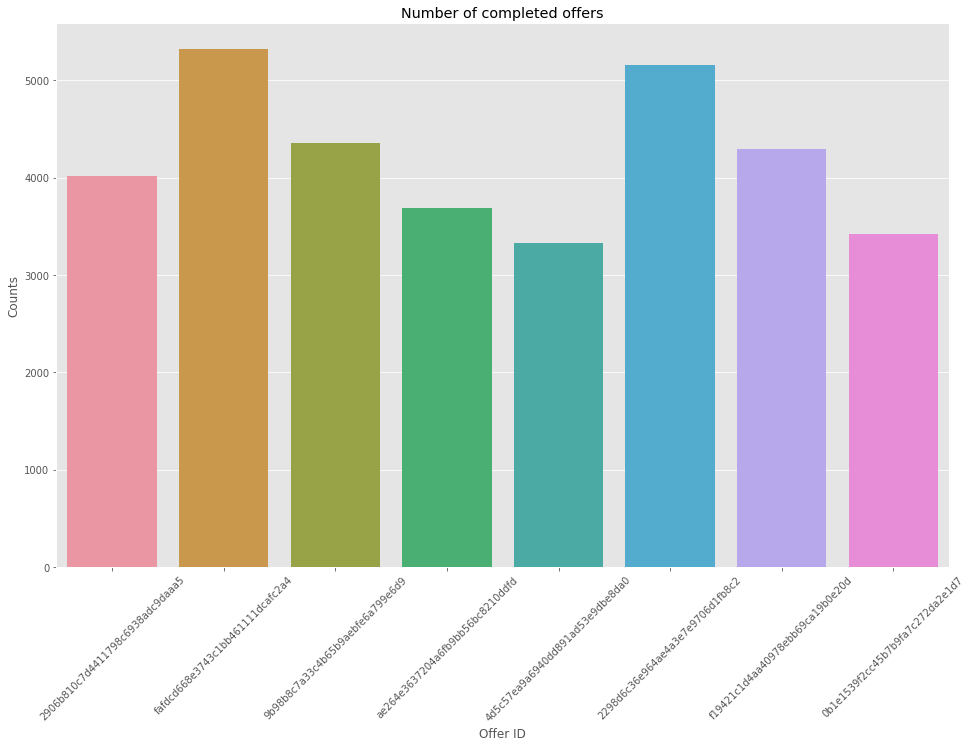

In [32]:
offers = new_transcript[new_transcript['offer completed']==1]
plt.figure(figsize=(16, 10))
sns.countplot(x=offers['offer_id'])
plt.title('Number of completed offers')
plt.xlabel('Offer ID')
plt.ylabel('Counts')
plt.xticks(rotation=45)
# plt.savefig('completed_offers.png', bbox_inches='tight')
plt.show()

**No. of Offers sent out**

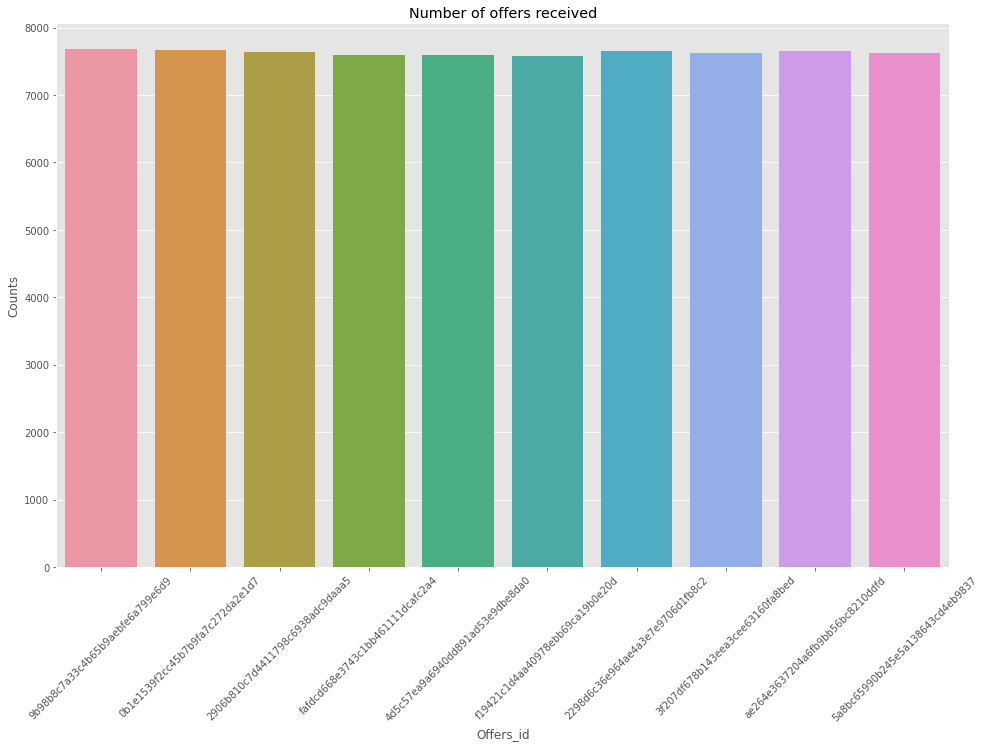

In [33]:
offers = new_transcript[new_transcript['offer received']==1]
plt.figure(figsize=(16, 10))
sns.countplot(x=offers['offer_id'])
plt.title('Number of offers received')
plt.xlabel('Offers_id')
plt.ylabel('Counts')
plt.xticks(rotation=45)
# plt.savefig('sent_offers.png', bbox_inches='tight')
plt.show()

## 2.4 Merging of the data
### Here we are going to merge all the data together

In [34]:
temp_data = new_transcript.merge(new_portfolio[new_portfolio.columns])
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   customer_id      167581 non-null  object
 1   time             167581 non-null  int64 
 2   offer_id         167581 non-null  object
 3   offer completed  167581 non-null  uint8 
 4   offer received   167581 non-null  uint8 
 5   offer viewed     167581 non-null  uint8 
 6   reward           167581 non-null  int64 
 7   difficulty       167581 non-null  int64 
 8   duration         167581 non-null  int64 
 9   web              167581 non-null  int64 
 10  email            167581 non-null  int64 
 11  mobile           167581 non-null  int64 
 12  social           167581 non-null  int64 
 13  bogo             167581 non-null  uint8 
 14  discount         167581 non-null  uint8 
 15  informational    167581 non-null  uint8 
dtypes: int64(8), object(2), uint8(6)
memory usage: 15.0+ MB


In [35]:
data = temp_data.merge(new_profile[new_profile.columns])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_id        148805 non-null  object        
 1   time               148805 non-null  int64         
 2   offer_id           148805 non-null  object        
 3   offer completed    148805 non-null  uint8         
 4   offer received     148805 non-null  uint8         
 5   offer viewed       148805 non-null  uint8         
 6   reward             148805 non-null  int64         
 7   difficulty         148805 non-null  int64         
 8   duration           148805 non-null  int64         
 9   web                148805 non-null  int64         
 10  email              148805 non-null  int64         
 11  mobile             148805 non-null  int64         
 12  social             148805 non-null  int64         
 13  bogo               148805 non-null  uint8   

In [107]:
data.columns

Index([      'customer_id',              'time',          'offer_id',
         'offer completed',    'offer received',      'offer viewed',
                  'reward',        'difficulty',          'duration',
                     'web',             'email',            'mobile',
                  'social',              'bogo',          'discount',
           'informational',            'gender',               'age',
        'became_member_on',                 'F',                 'M',
                       'O',      (30000, 40000],      (40000, 50000],
            (50000, 60000],      (60000, 70000],      (70000, 80000],
            (80000, 90000],     (90000, 100000],    (100000, 110000],
          (110000, 120000],             'child',              'teen',
            'young_adults', 'middle_age_adults',           'elderly'],
      dtype='object')

# 3. Descriptive Statistics and Information

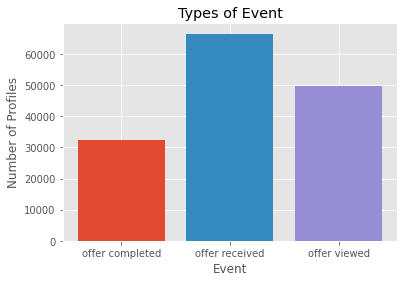

In [36]:
ax = plt.subplot()
cols = ['offer completed', 'offer received', 'offer viewed']
counts = data[cols].sum()

ax.bar(1, counts[0])
ax.bar(2, counts[1])
ax.bar(3, counts[2])

plt.title('Types of Event')
plt.ylabel('Number of Profiles')
plt.xlabel('Event')
plt.xticks([1, 2, 3], cols, rotation=0)
plt.show()

It can be seen that there is a low number of offers that are completed, so we are going to plot a graph and see which
types of customers complete them.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'child'),
  Text(1, 0, 'teen'),
  Text(2, 0, 'young_adults'),
  Text(3, 0, 'middle_age_adults'),
  Text(4, 0, 'elderly')])

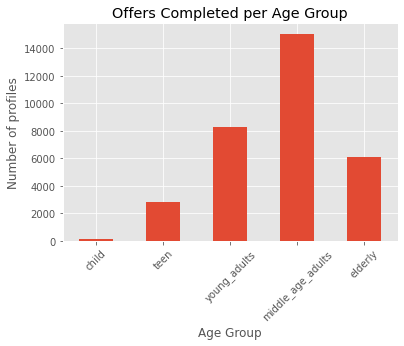

In [37]:
ax = plt.subplot()
groups = ['child', 'teen', 'young_adults', 'middle_age_adults', 'elderly']
data[data['offer completed']==1][groups].sum().plot.bar(ax=ax)
ax.set_title('Offers Completed per Age Group')
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of profiles')
# plt.savefig('offers_age_groups.png', bbox_inches='tight')
plt.xticks(rotation=45)

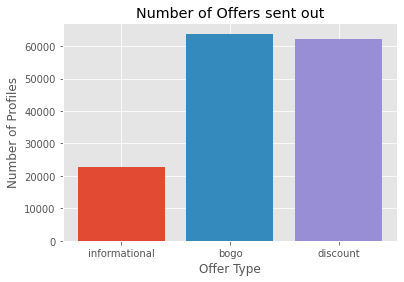

In [38]:
ax = plt.subplot()
cols = ['informational', 'bogo', 'discount']
counts = data[cols].sum()

ax.bar(1, counts[0])
ax.bar(2, counts[1])
ax.bar(3, counts[2])

plt.title('Number of Offers sent out')
plt.ylabel('Number of Profiles')
plt.xlabel('Offer Type')
plt.xticks([1, 2, 3], cols, rotation=0)
# plt.savefig('sent_out_offers.png', bbox_inches='tight')
plt.show()

### Popular offers among Age groups

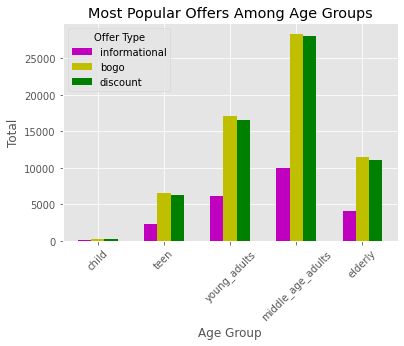

In [39]:
cols = ['informational', 'bogo', 'discount']
groups = ['child', 'teen', 'young_adults', 'middle_age_adults', 'elderly']
counts = [data[data[x]==1][cols].sum() for x in groups]
palette = ('m', 'y', 'g')
ax = plt.subplot(111)
b1 = ax.bar([0.8, 1, 1.2], list(counts[0].values), width=0.2, color=palette, align='center')
b2 = ax.bar([1.8, 2, 2.2], list(counts[1].values), width=0.2, color=palette, align='center')
b3 = ax.bar([2.8, 3, 3.2], list(counts[2].values), width=0.2, color=palette, align='center')
b4 = ax.bar([3.8, 4, 4.2], list(counts[3].values), width=0.2, color=palette, align='center')
b5 = ax.bar([4.8, 5, 5.2], list(counts[4].values), width=0.2, color=palette, align='center')

plt.title('Most Popular Offers Among Age Groups')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks([1, 2, 3, 4, 5], groups, rotation=45)
plt.legend((b1[0], b1[1], b1[2]), ('informational', 'bogo', 'discount'), title='Offer Type')
# plt.savefig('popular_offers_age_groups.png', bbox_inches='tight')
plt.show()

### BOGO Offers among Age groups

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'child'),
  Text(1, 0, 'teen'),
  Text(2, 0, 'young_adults'),
  Text(3, 0, 'middle_age_adults'),
  Text(4, 0, 'elderly')])

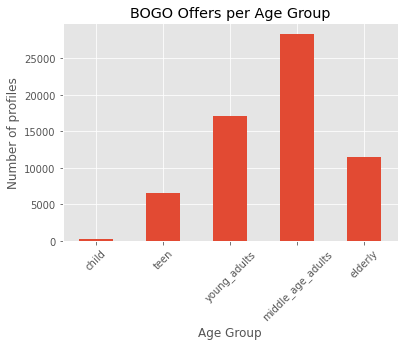

In [40]:
ax = plt.subplot()
groups = ['child', 'teen', 'young_adults', 'middle_age_adults', 'elderly']
data[data['bogo']==1][groups].sum().plot.bar(ax=ax)
ax.set_title('BOGO Offers per Age Group')
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of profiles')
plt.xticks(rotation=45)

## Female v. Male offer distribution

The following section will take a loop in whether or not the gender of the profile had any difference with regard to
the sent out offer.

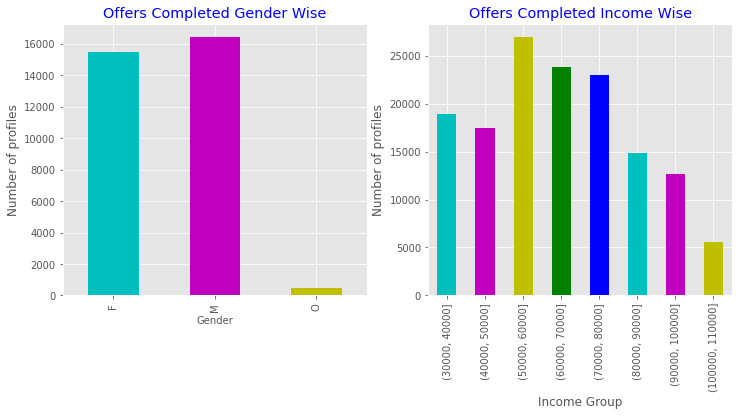

In [41]:
palette = ('c', 'm', 'y', 'g', 'b')
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# gender
data[data['offer completed']==1][['F','M','O']].sum().plot.bar(ax=ax[0], fontsize=10, color=palette)
ax[0].set_title('Offers Completed Gender Wise', color='blue')
ax[0].set_xlabel('Gender', fontsize=10)
ax[0].set_ylabel('Number of profiles')

# income group
data[data[data['offer completed']==1].columns[22:30]].sum().plot.bar(ax=ax[1], fontsize=10, color=palette)
ax[1].set_title('Offers Completed Income Wise', color='blue')
ax[1].set_xlabel('Income Group')
ax[1].set_ylabel('Number of profiles')
# plt.savefig('gender_income_groups.png', bbox_inches='tight')
plt.show()

From the above charts we can see that the offers that are completed are distributed across Gender and Income groups.
1. Based on the Gender, the Male category has completed the most offers with frequency abit above 16000 and the Female
category is close to 16000 and the other category has the minimum with near 1000.
2. Based on the Age group, the age groups of `Middle Age Adults` is the most active with completing offers followed by
`Young Adults` and the `Elderly`.
3. Based on the Income level, people with income ranging fromm 50-80k are the most active ones to complete offers.

In [42]:
# finding male/female profile with age 29-69 and age 30k -100k
male_data= orig_profile[(orig_profile['gender']=='M')& (orig_profile['age']>29)& (orig_profile['age']<69) & (orig_profile['income']>30000)\
                   & (orig_profile['income']<100000)]

female_data= orig_profile[(orig_profile['gender']=='F')& (orig_profile['age']>29)& (orig_profile['age']<69) & (orig_profile['income']>30000)\
                   & (orig_profile['income']<100000)]

In [43]:
# appending both together
merged_mf = male_data.append(female_data)
idx=[]
for person in merged_mf['id']:
    pass
    ids= data[data['customer_id']==person].index.tolist()
    idx.extend(ids)

In [44]:
percentage = len(idx) * 100 / data.shape[0]
print('{0:.2f}% of the clients from the ages of 29-69, and with income between 30,000-100,000 have completed offers.'.format(percentage))

62.35% of the clients from the ages of 29-69, and with income between 30,000-100,000 have completed offers.


### The most rewarding offers that are sent out to the customers

The BOGO offer with id `4d5c57ea9a6940dd891ad53e9dbe8da0` offers the most amount of reward but has one of the "hardest"
diffulties.

Discount offer with id `0b1e1539f2cc45b7b9fa7c272da2e1d7` offers a great discount price but has the hardest difficulty
and the longest completion time.

In [45]:
bogo_id = '4d5c57ea9a6940dd891ad53e9dbe8da0'
discount_id = '0b1e1539f2cc45b7b9fa7c272da2e1d7'
data_offerid = data[(data['offer_id']!= '0')].groupby(['offer_id']).sum()
data_offerid_event = data[(data['offer_id']!= '0')].groupby(['offer_id', 'offer completed', 'offer received', 'offer viewed']).count()

In [46]:
discount_df = data_offerid_event.loc[discount_id]
bogo_df = data_offerid_event.loc[bogo_id]

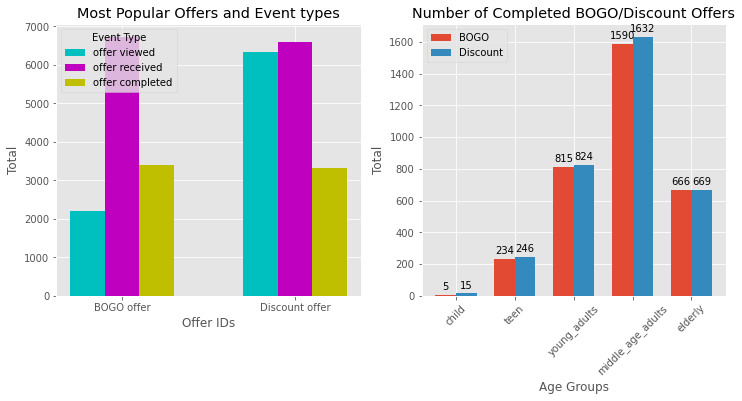

In [47]:
cols = ['offer viewed', 'offer received', 'offer completed']
groups = ['BOGO offer', 'Discount offer']

palette = ('c', 'm', 'y', 'g', 'b')
_, ax = plt.subplots(1, 2, figsize=(12,5))
b1 = ax[0].bar([0.8, 1, 1.2], list(discount_df['customer_id'].values), width=0.2, color=palette, align='center')
_ = ax[0].bar([1.8, 2, 2.2], list(bogo_df['customer_id'].values), width=0.2, color=palette, align='center')
ax[0].set_title('Most Popular Offers and Event types')
ax[0].set_ylabel('Total')
ax[0].set_xlabel('Offer IDs')
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(groups)
ax[0].legend((b1[0], b1[1], b1[2]), cols, title='Event Type')

ages = ['child', 'teen', 'young_adults', 'middle_age_adults', 'elderly']
discs = data[data['offer_id']==discount_id].groupby(['offer completed']).sum().loc[1]
bogs = data[data['offer_id']==bogo_id].groupby(['offer completed']).sum().loc[1]
bogos = [bogs[x] for x in ages]
discounts = [discs[x] for x in ages]

x = np.arange(len(ages))  # the label locations
width = 0.35

rects1 = ax[1].bar(x - width/2, bogos, width, label='BOGO')
rects2 = ax[1].bar(x + width/2, discounts, width, label='Discount')

ax[1].set_title('Number of Completed BOGO/Discount Offers')
ax[1].set_ylabel('Total')
ax[1].set_xlabel('Age Groups')
ax[1].set_xticks(x)
ax[1].set_xticklabels(ages, rotation=45)
ax[1].legend()
ax[1].bar_label(rects1, padding=3)
ax[1].bar_label(rects2, padding=3)
# plt.savefig('popular_bogo_discount.png', bbox_inches='tight')
plt.show()

It can also be seen that Discount offers receive a lot more views due their nature as an offer.

# 4. Data Wrangling and Train-Test Preparation

Our next step will involve the normalization of the data, droping some unnecessary columns, defining our target
attribute, and finally partitioning the data into training and testing sets.

In [48]:
data.columns

Index([      'customer_id',              'time',          'offer_id',
         'offer completed',    'offer received',      'offer viewed',
                  'reward',        'difficulty',          'duration',
                     'web',             'email',            'mobile',
                  'social',              'bogo',          'discount',
           'informational',            'gender',               'age',
        'became_member_on',                 'F',                 'M',
                       'O',      (30000, 40000],      (40000, 50000],
            (50000, 60000],      (60000, 70000],      (70000, 80000],
            (80000, 90000],     (90000, 100000],    (100000, 110000],
          (110000, 120000],             'child',              'teen',
            'young_adults', 'middle_age_adults',           'elderly'],
      dtype='object')

Define the target for our models and their features that are going to be trained on.

In [49]:
target = data['offer completed']
features = data.drop(columns=['customer_id', 'offer received', 'offer viewed', 'informational', 'offer_id',
                              'offer completed', 'became_member_on', 'gender'], axis=1)
print(" Number of total features: {} ".format(len(features.columns)))

 Number of total features: 28 


Next step is to normalize our numerical attributes in range of 0-1

In [50]:
scaler = MinMaxScaler()
numericals = ['time', 'difficulty', 'duration', 'reward']
scaled_features = features.copy()
scaled_features[numericals] = scaler.fit_transform(features[numericals])
# scaled_features = scaler.fit_transform(features)

In [51]:
scaled_features.columns

Index([             'time',            'reward',        'difficulty',
                'duration',               'web',             'email',
                  'mobile',            'social',              'bogo',
                'discount',               'age',                 'F',
                       'M',                 'O',      (30000, 40000],
            (40000, 50000],      (50000, 60000],      (60000, 70000],
            (70000, 80000],      (80000, 90000],     (90000, 100000],
          (100000, 110000],    (110000, 120000],             'child',
                    'teen',      'young_adults', 'middle_age_adults',
                 'elderly'],
      dtype='object')

In [108]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.3, random_state=42,
                                                    stratify=target)

print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])

print('\nTarget distribution')
print('Train set')
print(y_train.value_counts(normalize=True))
print('Test set')
print(y_test.value_counts(normalize=True))

Training samples: 104163
Testing samples: 44642

Target distribution
Train set
0    0.781967
1    0.218033
Name: offer completed, dtype: float64
Test set
0    0.781977
1    0.218023
Name: offer completed, dtype: float64


# 5. Creating the Benchmark Model and Evaluation Metrics

I will be using Logistic regression model as a benchmark model in which to compare our models' performance to because it
is fast and simple to implement.

We will implement the:
* ROC (Receiver Operating Characteristic) and AUC (Accuracy Under Curve) score,
* Precision: How many predicted values are relevant?
* Recall: How many relevant items are selected, and
* F1 score: A weighted average of the precision and recall

to compare the performance of the models.

We are going to create a function that will only require to pass the name of the classifier and the appropriate data
in order to be fit and then return the metric for their performance.

In [118]:
def train_test(clf, train_f, train_t, test_f, test_t):
    """
    Return the trained model along with a dictionary of metrics.

    Parameters
    ----------
    clf: classifier model for making predictions
    train_f: train data with features
    train_t: train data with targets
    test_f: test data with features
    test_t: test data with targets

    Returns
    -------
    clf: trained classifier
    res: a dictionary with metrics
    """
    res = dict()
    test_pred = clf.fit(train_f, train_t).predict(test_f)
    test_pred_prob = clf.predict_proba(test_f)

    res['proba'] = test_pred_prob[:, 1]
    res['accuracy'] = round(accuracy_score(test_t, test_pred), 2)
    res['precision'] = round(precision_score(test_t, test_pred), 2)
    res['recall'] = round(recall_score(test_t, test_pred), 2)
    res['auc'] = round(roc_auc_score(test_t, test_pred_prob[:, 1]), 2)
    res['f1'] = round(f1_score(test_t, test_pred), 2)
    res['mse'] = round(mean_squared_error(test_t, test_pred), 2)
    res['confusion_matrix'] = confusion_matrix(test_t, test_pred)

    return clf, res

We are going to be using as our base model LogisticRegression, which is a fairly simple model to implement and does not
require much time and resources.

* Logistic Regression : model using logistic function to predict the result
* Decision Tree Classifier : model using series decision nodes to predict the result
* Random Forest Classifier : model using multiple decision tree classifier to predict the result

In [54]:
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

LogisticRegression Precision score: 0.58
[[34893    16]
 [ 9711    22]]


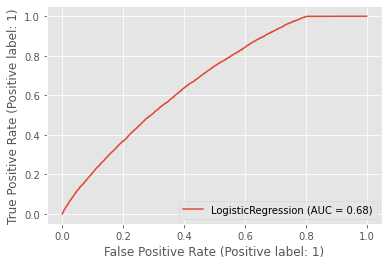

In [109]:
_, results = train_test(lr, X_train, y_train, X_test, y_test)
print(lr.__class__.__name__, 'Precision score:', results['precision'])
print(results['confusion_matrix'])
plot_roc_curve(lr, X_test, y_test)
plt.show()

As it can be seen the model assumes that almost everyone will complete an offer that they receive, while for people who
**ARE** going to complete the offer the model works perfectly, for people that are **NOT** going to complete an offer
we have almost all of our samples falsely categorized.

DecisionTreeClassifier Precision score: 0.5
[[30490  4419]
 [ 5342  4391]]


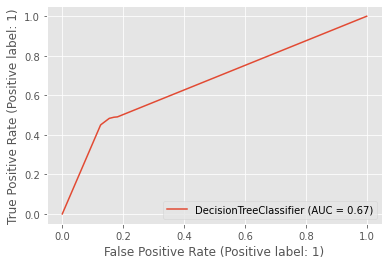

In [110]:
_, results = train_test(dt, X_train, y_train, X_test, y_test)
print(dt.__class__.__name__, 'Precision score:', results['precision'])
print(results['confusion_matrix'])
plot_roc_curve(dt, X_test, y_test)
plt.show()

Now the DecisionTree classifier, while for the most part it has categorized people that **ARE** going to complete offers
correctly, for people that are **NOT** going to complete any offers it shows mixed results.

While we do not mind the model categorizing people completing offers in to **NOT** completing them because.

RandomForestClassifier Precision score: 0.41
[[30966  3943]
 [ 6994  2739]]


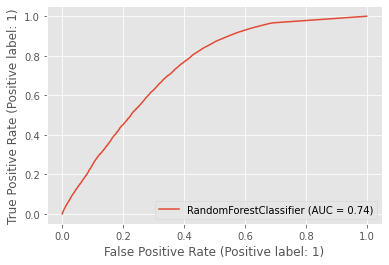

In [111]:
_, results = train_test(rf, X_train, y_train, X_test, y_test)
print(rf.__class__.__name__, 'Precision score:', results['precision'])
print(results['confusion_matrix'])
plot_roc_curve(rf, X_test, y_test)
plt.show()

Lastly, the RandomForrest classifier has done fairly remarkable work compared with the other 2 previous models. In
general, we want the ROC curve to be as 90 degrees as possible, meaning almost 100% accuracy of model's predictions.

## First Run Thoughs

On a first run we can see that each model tries to predict that a customer **will** complete an offer but in reality
they are **not** completing the offer or vice versa.

The LogisticRegression model wants to predict that EVERYONE will complete an offer.
But the DecisionTree and RandomForest classifiers are a bit different and manage to identify which are the ones that
will and will not complete offers.

In order to fight this false negative/positive trend we will apply some methods, like K-Fold, in order to see whether or
not the results will be different, either for the better or not of our model's efficiency.

### K-Fold cross-validator

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling
by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

Splitting our data with K-Fold results in a better performing model.

In [59]:
k_fold, results = KFold(n_splits=10, shuffle=True, random_state=42), list()
for model in [lr, dt, rf]:
    scores = list()
    for train_index, test_index in k_fold.split(scaled_features):
        X_train_, X_test_ = scaled_features.iloc[train_index], scaled_features.iloc[test_index]
        y_train_, y_test_ = target.iloc[train_index], target.iloc[test_index]

        model, temp_res = train_test(model, X_train_, y_train_, X_test_, y_test_)
        results.append(temp_res)
        scores.append(temp_res['precision'])

    print(model.__class__.__name__, 'Mean precision:', np.mean(scores))

LogisticRegression Mean precision: 0.394
DecisionTreeClassifier Mean precision: 0.499
RandomForestClassifier Mean precision: 0.4125


While K-Folds may not exactly increase the precision of each model, there are always different methods to try.

### GridSearch

Our next step will be to try to apply `GridSearchCV`, which is a hyperparameter optimization technique.

Hyperparameter optimization is the search of certain variables, that a machine learning model utilizes during its
training, that determine and optimize the performance, they are key characteristics, such as choosing a different
learning method, the max depth of a decision tree, or the number of hidden layers in a neural network etc.

In [60]:
hyper_params = [
    {'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]},
    {'criterion': ['gini', 'entropy'],
     'max_depth': range(1,10),
     'min_samples_split': range(1,10),
     'min_samples_leaf': range(1,5)},
    {'max_depth':[2,5,10], 'n_estimators':[100,300]}
]

In [61]:
for model, param_grid in zip([lr, dt, rf], hyper_params):
    grid_search = GridSearchCV(model, param_grid)
    grid_search.fit(X_train, y_train)
    print(model.__class__.__name__, 'Best hyper params:', grid_search.best_params_)

LogisticRegression Best hyper params: {'C': 0.5}
DecisionTreeClassifier Best hyper params: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 9}
RandomForestClassifier Best hyper params: {'max_depth': 10, 'n_estimators': 300}


And based from the above results from the GridSearch we are going to apply them to our models and see if there is any
better performance

In [119]:
lr_ = LogisticRegression(C=0.5, solver='liblinear', random_state=42)
_, lr_results = train_test(lr_, X_train, y_train, X_test, y_test)
print(lr_.__class__.__name__, 'Precision score:', lr_results['precision'])
print(lr_results['confusion_matrix'])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_results['proba'])

LogisticRegression Precision score: 0.0
[[34909     0]
 [ 9733     0]]


As it can be seen the LogisticRegression model classified everyone as if they would all complete a sent out offer

In [120]:
dt_ = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=4, min_samples_split=9, random_state=42)
_, dt_results = train_test(dt_, X_train, y_train, X_test, y_test)
print(dt_.__class__.__name__, 'Precision score:', dt_results['precision'])
print(dt_results['confusion_matrix'])
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_results['proba'])

DecisionTreeClassifier Precision score: 0.61
[[32361  2548]
 [ 5679  4054]]


In [121]:
rf_ = RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)
_, rf_results = train_test(rf_, X_train, y_train, X_test, y_test)
print(rf_.__class__.__name__, 'Precision score:', rf_results['precision'])
print(rf_results['confusion_matrix'])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_results['proba'])

RandomForestClassifier Precision score: 0.65
[[34213   696]
 [ 8451  1282]]


In [122]:
for r in [lr_results, dt_results, rf_results]:
    r.pop('proba')

In [123]:
lr_results

{'accuracy': 0.78,
 'precision': 0.0,
 'recall': 0.0,
 'auc': 0.68,
 'f1': 0.0,
 'mse': 0.22,
 'confusion_matrix': array([[34909,     0],
        [ 9733,     0]], dtype=int64)}

In [124]:
df_lr = pd.DataFrame.from_dict(data=lr_results, orient='index', columns=['Logistic Regression'])
df_dt = pd.DataFrame.from_dict(data=dt_results, orient='index', columns=['Decision Tree'])
df_rf = pd.DataFrame.from_dict(data=rf_results, orient='index', columns=['Random Forest'])
pd.concat([df_lr, df_dt, df_rf], axis=1)

,Logistic Regression,Decision Tree,Random Forest
accuracy,0.78,0.82,0.8
precision,0.0,0.61,0.65
recall,0.0,0.42,0.13
auc,0.68,0.83,0.75
f1,0.0,0.5,0.22
mse,0.22,0.18,0.2
confusion_matrix,"[[34909, 0], [9733, 0]]","[[32361, 2548], [5679, 4054]]","[[34213, 696], [8451, 1282]]"


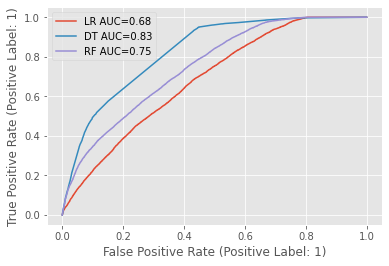

In [126]:
plt.plot(lr_fpr, lr_tpr, label='LR AUC='+str(lr_results['auc']))
plt.plot(dt_fpr, dt_tpr, label='DT AUC='+str(dt_results['auc']))
plt.plot(rf_fpr, rf_tpr, label='RF AUC='+str(rf_results['auc']))
plt.legend()
plt.ylabel('True Positive Rate (Positive Label: 1)')
plt.xlabel('False Positive Rate (Positive Label: 1)')
# plt.savefig('models_auc.png')
plt.show()

# Conclusion

So now we have to decide which one is the best model, and we have two types of wrong values:

* False Positive, means the client in reality did **NOT COMPLETE** an offer, but the **MODEL** thinks/predicts they did,
which is called a **Type I Error**.
* False Negative, means the client in reality **COMPLETED** an offer, but the **MODEL** thinks/predicts they didn't,
which is called a **Type II Error**

In my opinion:
* Type II error is the most harmful, because the model thinks that a customer **WILL NOT** complete an offer, but of
course in reality they did, and the reason behind this is that our model is not able to find the "loyal" customers, the
ones that complete offers.
* Type I error  is not good, but it's ok, because in the end we try to find new customers that **maybe** complete offers
that are sent out to them, and of course we are going to find some bumbs in the road, as the saying tells, in order to
find those.

Now based on the resultant confusion matrices one could say that using a simple LogisticRegression will suffice, because
it thinks that everyone will complete an offer and the business needs more and more users to buy their products through
their sent out offers or not.

Theoretically, there is no harm that **BUT** the constant notifications and reminders of new offers may irritate some
customers and may result in using less and less the brand and the product.